In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.neural_network import MLPClassifier
import time

In [39]:
from ffnn import FFNN
from activation_functions import (
    linear, relu, tanh, sigmoid, softmax
)
from visualization import (
    visualize_model, 
    plot_weight_distribution, 
    plot_gradient_distribution, 
    plot_training_history, 
    visualize_predictions
)

In [40]:
# Seed for reproducibility
np.random.seed(42)

In [41]:
# Load MNIST Dataset
def load_mnist_data():
    """Load and preprocess MNIST dataset"""
    print("Loading MNIST dataset...")
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    
    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Convert labels to one-hot encoded format
    lb = LabelBinarizer()
    y_onehot = lb.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
    
    # Create smaller subset for faster testing
    X_train_small = X_train[:5000]
    y_train_small = y_train[:5000]
    X_test_small = X_test[:1000]
    y_test_small = y_test[:1000]
    
    return (X_train_small, y_train_small, X_test_small, y_test_small), lb

In [42]:
# 1. Analysis of Network Depth and Width
def test_network_depth_and_width():
    (X_train, y_train, X_test, y_test), lb = load_mnist_data()
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    
    # Depth and Width Variations
    depth_variations = [
        {'layer_sizes': [input_size, 64, output_size], 'name': '2 Layers'},
        {'layer_sizes': [input_size, 64, 64, output_size], 'name': '3 Layers'},
        {'layer_sizes': [input_size, 64, 64, 64, output_size], 'name': '4 Layers'}
    ]
    
    width_variations = [
        {'layer_sizes': [input_size, 32, output_size], 'name': '32 Neurons'},
        {'layer_sizes': [input_size, 128, output_size], 'name': '128 Neurons'},
        {'layer_sizes': [input_size, 256, output_size], 'name': '256 Neurons'}
    ]
    
    # Depth Analysis
    depth_results = {}
    for var in depth_variations:
        model = FFNN(
            layer_sizes=var['layer_sizes'],
            activation_functions=['linear'] + ['relu'] * (len(var['layer_sizes']) - 2) + ['sigmoid'],
            loss_function='binary_cross_entropy',
            weight_init_method='uniform'
        )
        history = model.fit(X_train, y_train, X_val=X_test, y_val=y_test, epochs=10)
        y_pred = model.predict(X_test)
        y_pred_labels = lb.inverse_transform(y_pred)
        y_true_labels = lb.inverse_transform(y_test)
        depth_results[var['name']] = {
            'history': history,
            'accuracy': np.mean(y_pred_labels == y_true_labels)
        }
    
    # Width Analysis
    width_results = {}
    for var in width_variations:
        model = FFNN(
            layer_sizes=var['layer_sizes'],
            activation_functions=['linear'] + ['relu'] * (len(var['layer_sizes']) - 2) + ['sigmoid'],
            loss_function='binary_cross_entropy',
            weight_init_method='uniform'
        )
        history = model.fit(X_train, y_train, X_val=X_test, y_val=y_test, epochs=10)
        y_pred = model.predict(X_test)
        y_pred_labels = lb.inverse_transform(y_pred)
        y_true_labels = lb.inverse_transform(y_test)
        width_results[var['name']] = {
            'history': history,
            'accuracy': np.mean(y_pred_labels == y_true_labels)
        }
    
    return depth_results, width_results

In [43]:
# 2. Activation Function Analysis
def test_activation_functions():
    (X_train, y_train, X_test, y_test), lb = load_mnist_data()
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    
    # Activation Functions to Test (excluding softmax)
    activation_functions = ['linear', 'relu', 'tanh', 'sigmoid']
    
    results = {}
    for activation in activation_functions:
        model = FFNN(
            layer_sizes=[input_size, 128, output_size],
            activation_functions=['linear', activation, 'sigmoid'],
            loss_function='binary_cross_entropy',
            weight_init_method='uniform'
        )
        history = model.fit(X_train, y_train, X_val=X_test, y_val=y_test, epochs=10)
        y_pred = model.predict(X_test)
        y_pred_labels = lb.inverse_transform(y_pred)
        y_true_labels = lb.inverse_transform(y_test)
        results[activation] = {
            'history': history,
            'accuracy': np.mean(y_pred_labels == y_true_labels),
            'model': model
        }
    
    return results

In [44]:
# 3. Learning Rate Analysis
def test_learning_rates():
    (X_train, y_train, X_test, y_test), lb = load_mnist_data()
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    
    learning_rates = [0.001, 0.01, 0.1]
    
    results = {}
    for lr in learning_rates:
        model = FFNN(
            layer_sizes=[input_size, 128, output_size],
            activation_functions=['linear', 'relu', 'sigmoid'],
            loss_function='binary_cross_entropy',
            weight_init_method='uniform'
        )
        history = model.fit(
            X_train, y_train, 
            X_val=X_test, y_val=y_test, 
            learning_rate=lr, 
            epochs=10
        )
        y_pred = model.predict(X_test)
        y_pred_labels = lb.inverse_transform(y_pred)
        y_true_labels = lb.inverse_transform(y_test)
        results[lr] = {
            'history': history,
            'accuracy': np.mean(y_pred_labels == y_true_labels),
            'model': model
        }
    
    return results

In [45]:
# 4. Weight Initialization Analysis
def test_weight_initialization():
    (X_train, y_train, X_test, y_test), lb = load_mnist_data()
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    
    init_methods = ['uniform', 'normal', 'zero']
    
    results = {}
    for method in init_methods:
        model = FFNN(
            layer_sizes=[input_size, 128, output_size],
            activation_functions=['linear', 'relu', 'sigmoid'],
            loss_function='binary_cross_entropy',
            weight_init_method=method
        )
        history = model.fit(X_train, y_train, X_val=X_test, y_val=y_test, epochs=10)
        y_pred = model.predict(X_test)
        y_pred_labels = lb.inverse_transform(y_pred)
        y_true_labels = lb.inverse_transform(y_test)
        results[method] = {
            'history': history,
            'accuracy': np.mean(y_pred_labels == y_true_labels),
            'model': model
        }
    
    return results

In [46]:
# 5. Sklearn MLP Comparison
def test_sklearn_mlp_comparison():
    (X_train, y_train, X_test, y_test), lb = load_mnist_data()
    
    # Custom FFNN
    ffnn_model = FFNN(
        layer_sizes=[X_train.shape[1], 128, y_train.shape[1]],
        activation_functions=['linear', 'relu', 'sigmoid'],
        loss_function='binary_cross_entropy',
        weight_init_method='uniform'
    )
    ffnn_history = ffnn_model.fit(X_train, y_train, X_val=X_test, y_val=y_test, epochs=10)
    ffnn_pred = ffnn_model.predict(X_test)
    ffnn_pred_labels = lb.inverse_transform(ffnn_pred)
    ffnn_true_labels = lb.inverse_transform(y_test)
    ffnn_accuracy = np.mean(ffnn_pred_labels == ffnn_true_labels)
    
    # Sklearn MLP
    sklearn_mlp = MLPClassifier(
        hidden_layer_sizes=(128,),
        activation='relu',
        solver='sgd',
        learning_rate_init=0.01,
        max_iter=10,
        random_state=42
    )
    
    # Convert one-hot encoded labels back to categorical
    y_train_cat = np.argmax(y_train, axis=1)
    
    sklearn_mlp.fit(X_train, y_train_cat)
    sklearn_pred = sklearn_mlp.predict(X_test)
    sklearn_pred_oh = lb.transform(sklearn_pred)
    sklearn_true_labels = lb.inverse_transform(y_test)
    sklearn_accuracy = np.mean(sklearn_pred == np.argmax(y_test, axis=1))
    
    return {
        'FFNN': {
            'accuracy': ffnn_accuracy,
            'history': ffnn_history
        },
        'Sklearn MLP': {
            'accuracy': sklearn_accuracy
        }
    }

In [47]:
# Run all tests
def run_comprehensive_tests():
    print("1. Network Depth and Width Analysis")
    depth_results, width_results = test_network_depth_and_width()

    print("\n2. Activation Functions Analysis")
    activation_results = test_activation_functions()

    print("\n3. Learning Rate Analysis")
    lr_results = test_learning_rates()
    
    print("\n4. Weight Initialization Analysis")
    init_results = test_weight_initialization()
    
    print("\n5. Sklearn MLP Comparison")
    mlp_comparison = test_sklearn_mlp_comparison()

    return depth_results, width_results, activation_results, lr_results, init_results, mlp_comparison

In [48]:
depth_results, width_results, activation_results, lr_results, init_results, mlp_comparison = run_comprehensive_tests()

1. Network Depth and Width Analysis
Loading MNIST dataset...


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 327.21it/s, train_loss=1.3951]


Epoch 1/10 - train_loss: 1.3951 - val_loss: 1.2609


Epoch 2/10: 100%|██████████| 157/157 [00:00<00:00, 354.07it/s, train_loss=1.0075]


Epoch 2/10 - train_loss: 1.0075 - val_loss: 0.8770


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 137.01it/s, train_loss=0.7372]


Epoch 3/10 - train_loss: 0.7372 - val_loss: 0.7089


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 112.48it/s, train_loss=0.5963]


Epoch 4/10 - train_loss: 0.5963 - val_loss: 0.6213


Epoch 5/10: 100%|██████████| 157/157 [00:00<00:00, 298.00it/s, train_loss=0.5139]


Epoch 5/10 - train_loss: 0.5139 - val_loss: 0.5528


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 212.03it/s, train_loss=0.4513]


Epoch 6/10 - train_loss: 0.4513 - val_loss: 0.5116


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 202.32it/s, train_loss=0.4073]


Epoch 7/10 - train_loss: 0.4073 - val_loss: 0.4849


Epoch 8/10: 100%|██████████| 157/157 [00:01<00:00, 119.96it/s, train_loss=0.3755]


Epoch 8/10 - train_loss: 0.3755 - val_loss: 0.4592


Epoch 9/10: 100%|██████████| 157/157 [00:00<00:00, 178.05it/s, train_loss=0.3491]


Epoch 9/10 - train_loss: 0.3491 - val_loss: 0.4415


Epoch 10/10: 100%|██████████| 157/157 [00:00<00:00, 185.05it/s, train_loss=0.3266]


Epoch 10/10 - train_loss: 0.3266 - val_loss: 0.4291


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 286.93it/s, train_loss=1.7283]


Epoch 1/10 - train_loss: 1.7283 - val_loss: 1.9436


Epoch 2/10: 100%|██████████| 157/157 [00:00<00:00, 250.92it/s, train_loss=1.5986]


Epoch 2/10 - train_loss: 1.5986 - val_loss: 1.2913


Epoch 3/10: 100%|██████████| 157/157 [00:00<00:00, 262.65it/s, train_loss=1.0825]


Epoch 3/10 - train_loss: 1.0825 - val_loss: 0.9673


Epoch 4/10: 100%|██████████| 157/157 [00:00<00:00, 290.99it/s, train_loss=0.8217]


Epoch 4/10 - train_loss: 0.8217 - val_loss: 0.7861


Epoch 5/10: 100%|██████████| 157/157 [00:00<00:00, 180.33it/s, train_loss=0.6565]


Epoch 5/10 - train_loss: 0.6565 - val_loss: 0.6698


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 303.89it/s, train_loss=0.5507]


Epoch 6/10 - train_loss: 0.5507 - val_loss: 0.5784


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 309.24it/s, train_loss=0.4768]


Epoch 7/10 - train_loss: 0.4768 - val_loss: 0.5222


Epoch 8/10: 100%|██████████| 157/157 [00:00<00:00, 164.87it/s, train_loss=0.4216]


Epoch 8/10 - train_loss: 0.4216 - val_loss: 0.4951


Epoch 9/10: 100%|██████████| 157/157 [00:00<00:00, 216.69it/s, train_loss=0.3809]


Epoch 9/10 - train_loss: 0.3809 - val_loss: 0.4433


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 138.92it/s, train_loss=0.3450]


Epoch 10/10 - train_loss: 0.3450 - val_loss: 0.4302


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 256.96it/s, train_loss=1.5952]


Epoch 1/10 - train_loss: 1.5952 - val_loss: 2.2114


Epoch 2/10: 100%|██████████| 157/157 [00:00<00:00, 280.79it/s, train_loss=2.1433]


Epoch 2/10 - train_loss: 2.1433 - val_loss: 2.0468


Epoch 3/10: 100%|██████████| 157/157 [00:00<00:00, 242.81it/s, train_loss=1.8372]


Epoch 3/10 - train_loss: 1.8372 - val_loss: 1.6494


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 152.46it/s, train_loss=1.3936]


Epoch 4/10 - train_loss: 1.3936 - val_loss: 1.2520


Epoch 5/10: 100%|██████████| 157/157 [00:00<00:00, 204.73it/s, train_loss=1.0451]


Epoch 5/10 - train_loss: 1.0451 - val_loss: 1.0038


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 237.21it/s, train_loss=0.8298]


Epoch 6/10 - train_loss: 0.8298 - val_loss: 0.8256


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 264.03it/s, train_loss=0.6843]


Epoch 7/10 - train_loss: 0.6843 - val_loss: 0.6749


Epoch 8/10: 100%|██████████| 157/157 [00:00<00:00, 230.03it/s, train_loss=0.5812]


Epoch 8/10 - train_loss: 0.5812 - val_loss: 0.6090


Epoch 9/10: 100%|██████████| 157/157 [00:00<00:00, 202.42it/s, train_loss=0.5030]


Epoch 9/10 - train_loss: 0.5030 - val_loss: 0.5639


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 106.28it/s, train_loss=0.4418]


Epoch 10/10 - train_loss: 0.4418 - val_loss: 0.5153


Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 136.56it/s, train_loss=1.3666]


Epoch 1/10 - train_loss: 1.3666 - val_loss: 1.4379


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 128.09it/s, train_loss=1.1173]


Epoch 2/10 - train_loss: 1.1173 - val_loss: 0.9633


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 119.68it/s, train_loss=0.7863]


Epoch 3/10 - train_loss: 0.7863 - val_loss: 0.7798


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 119.03it/s, train_loss=0.6429]


Epoch 4/10 - train_loss: 0.6429 - val_loss: 0.6743


Epoch 5/10: 100%|██████████| 157/157 [00:01<00:00, 88.92it/s, train_loss=0.5541] 


Epoch 5/10 - train_loss: 0.5541 - val_loss: 0.5995


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 128.49it/s, train_loss=0.4913]


Epoch 6/10 - train_loss: 0.4913 - val_loss: 0.5688


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 239.67it/s, train_loss=0.4497]


Epoch 7/10 - train_loss: 0.4497 - val_loss: 0.5226


Epoch 8/10: 100%|██████████| 157/157 [00:00<00:00, 166.62it/s, train_loss=0.4134]


Epoch 8/10 - train_loss: 0.4134 - val_loss: 0.5015


Epoch 9/10: 100%|██████████| 157/157 [00:00<00:00, 177.47it/s, train_loss=0.3854]


Epoch 9/10 - train_loss: 0.3854 - val_loss: 0.4847


Epoch 10/10: 100%|██████████| 157/157 [00:00<00:00, 265.60it/s, train_loss=0.3639]


Epoch 10/10 - train_loss: 0.3639 - val_loss: 0.4663


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 173.20it/s, train_loss=1.3146]


Epoch 1/10 - train_loss: 1.3146 - val_loss: 1.0304


Epoch 2/10: 100%|██████████| 157/157 [00:04<00:00, 36.86it/s, train_loss=0.8469] 


Epoch 2/10 - train_loss: 0.8469 - val_loss: 0.7409


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 129.25it/s, train_loss=0.6366]


Epoch 3/10 - train_loss: 0.6366 - val_loss: 0.6361


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 118.41it/s, train_loss=0.5284]


Epoch 4/10 - train_loss: 0.5284 - val_loss: 0.5616


Epoch 5/10: 100%|██████████| 157/157 [00:01<00:00, 135.58it/s, train_loss=0.4596]


Epoch 5/10 - train_loss: 0.4596 - val_loss: 0.5150


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 180.67it/s, train_loss=0.4092]


Epoch 6/10 - train_loss: 0.4092 - val_loss: 0.4879


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 224.54it/s, train_loss=0.3711]


Epoch 7/10 - train_loss: 0.3711 - val_loss: 0.4642


Epoch 8/10: 100%|██████████| 157/157 [00:00<00:00, 169.72it/s, train_loss=0.3429]


Epoch 8/10 - train_loss: 0.3429 - val_loss: 0.4439


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 150.57it/s, train_loss=0.3190]


Epoch 9/10 - train_loss: 0.3190 - val_loss: 0.4249


Epoch 10/10: 100%|██████████| 157/157 [00:00<00:00, 186.13it/s, train_loss=0.2979]


Epoch 10/10 - train_loss: 0.2979 - val_loss: 0.4102


Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 108.60it/s, train_loss=1.1734]


Epoch 1/10 - train_loss: 1.1734 - val_loss: 0.8718


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 86.05it/s, train_loss=0.7082]


Epoch 2/10 - train_loss: 0.7082 - val_loss: 0.6872


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 116.00it/s, train_loss=0.5458]


Epoch 3/10 - train_loss: 0.5458 - val_loss: 0.5904


Epoch 4/10: 100%|██████████| 157/157 [00:02<00:00, 66.13it/s, train_loss=0.4584]


Epoch 4/10 - train_loss: 0.4584 - val_loss: 0.5340


Epoch 5/10: 100%|██████████| 157/157 [00:03<00:00, 48.91it/s, train_loss=0.3971]


Epoch 5/10 - train_loss: 0.3971 - val_loss: 0.5170


Epoch 6/10: 100%|██████████| 157/157 [00:03<00:00, 39.56it/s, train_loss=0.3607]


Epoch 6/10 - train_loss: 0.3607 - val_loss: 0.4841


Epoch 7/10: 100%|██████████| 157/157 [00:02<00:00, 65.88it/s, train_loss=0.3288]


Epoch 7/10 - train_loss: 0.3288 - val_loss: 0.4620


Epoch 8/10: 100%|██████████| 157/157 [00:02<00:00, 76.68it/s, train_loss=0.3029]


Epoch 8/10 - train_loss: 0.3029 - val_loss: 0.4467


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 85.08it/s, train_loss=0.2809]


Epoch 9/10 - train_loss: 0.2809 - val_loss: 0.4389


Epoch 10/10: 100%|██████████| 157/157 [00:02<00:00, 77.15it/s, train_loss=0.2614]


Epoch 10/10 - train_loss: 0.2614 - val_loss: 0.4309

2. Activation Functions Analysis
Loading MNIST dataset...


Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 104.12it/s, train_loss=0.4278]


Epoch 1/10 - train_loss: 0.4278 - val_loss: 0.4558


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 85.68it/s, train_loss=0.5373] 


Epoch 2/10 - train_loss: 0.5373 - val_loss: 0.5721


Epoch 3/10: 100%|██████████| 157/157 [00:00<00:00, 167.08it/s, train_loss=0.5474]


Epoch 3/10 - train_loss: 0.5474 - val_loss: 0.5515


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 103.75it/s, train_loss=0.5087]


Epoch 4/10 - train_loss: 0.5087 - val_loss: 0.5102


Epoch 5/10: 100%|██████████| 157/157 [00:02<00:00, 61.97it/s, train_loss=0.4717] 


Epoch 5/10 - train_loss: 0.4717 - val_loss: 0.4876


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 109.05it/s, train_loss=0.4454]


Epoch 6/10 - train_loss: 0.4454 - val_loss: 0.4686


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 157.39it/s, train_loss=0.4212]


Epoch 7/10 - train_loss: 0.4212 - val_loss: 0.4718


Epoch 8/10: 100%|██████████| 157/157 [00:00<00:00, 254.10it/s, train_loss=0.4103]


Epoch 8/10 - train_loss: 0.4103 - val_loss: 0.4607


Epoch 9/10: 100%|██████████| 157/157 [00:00<00:00, 183.61it/s, train_loss=0.3968]


Epoch 9/10 - train_loss: 0.3968 - val_loss: 0.4603


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 81.12it/s, train_loss=0.3879] 


Epoch 10/10 - train_loss: 0.3879 - val_loss: 0.4395


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 176.16it/s, train_loss=1.3146]


Epoch 1/10 - train_loss: 1.3146 - val_loss: 1.0304


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 136.98it/s, train_loss=0.8469]


Epoch 2/10 - train_loss: 0.8469 - val_loss: 0.7409


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 103.05it/s, train_loss=0.6366]


Epoch 3/10 - train_loss: 0.6366 - val_loss: 0.6361


Epoch 4/10: 100%|██████████| 157/157 [00:00<00:00, 168.88it/s, train_loss=0.5284]


Epoch 4/10 - train_loss: 0.5284 - val_loss: 0.5616


Epoch 5/10: 100%|██████████| 157/157 [00:01<00:00, 136.40it/s, train_loss=0.4596]


Epoch 5/10 - train_loss: 0.4596 - val_loss: 0.5150


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 217.40it/s, train_loss=0.4092]


Epoch 6/10 - train_loss: 0.4092 - val_loss: 0.4879


Epoch 7/10: 100%|██████████| 157/157 [00:01<00:00, 95.37it/s, train_loss=0.3711] 


Epoch 7/10 - train_loss: 0.3711 - val_loss: 0.4642


Epoch 8/10: 100%|██████████| 157/157 [00:01<00:00, 150.25it/s, train_loss=0.3429]


Epoch 8/10 - train_loss: 0.3429 - val_loss: 0.4439


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 118.36it/s, train_loss=0.3190]


Epoch 9/10 - train_loss: 0.3190 - val_loss: 0.4249


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 82.94it/s, train_loss=0.2979]


Epoch 10/10 - train_loss: 0.2979 - val_loss: 0.4102


Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 98.21it/s, train_loss=0.5439] 


Epoch 1/10 - train_loss: 0.5439 - val_loss: 0.5020


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 155.58it/s, train_loss=0.5163]


Epoch 2/10 - train_loss: 0.5163 - val_loss: 0.5584


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 86.09it/s, train_loss=0.5648] 


Epoch 3/10 - train_loss: 0.5648 - val_loss: 0.5850


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 126.54it/s, train_loss=0.5693]


Epoch 4/10 - train_loss: 0.5693 - val_loss: 0.5675


Epoch 5/10: 100%|██████████| 157/157 [00:00<00:00, 241.46it/s, train_loss=0.5398]


Epoch 5/10 - train_loss: 0.5398 - val_loss: 0.5385


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 88.30it/s, train_loss=0.5048]


Epoch 6/10 - train_loss: 0.5048 - val_loss: 0.5094


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 183.45it/s, train_loss=0.4707]


Epoch 7/10 - train_loss: 0.4707 - val_loss: 0.4834


Epoch 8/10: 100%|██████████| 157/157 [00:01<00:00, 126.76it/s, train_loss=0.4436]


Epoch 8/10 - train_loss: 0.4436 - val_loss: 0.4629


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 82.29it/s, train_loss=0.4188]


Epoch 9/10 - train_loss: 0.4188 - val_loss: 0.4468


Epoch 10/10: 100%|██████████| 157/157 [00:00<00:00, 163.45it/s, train_loss=0.3985]


Epoch 10/10 - train_loss: 0.3985 - val_loss: 0.4313


Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 104.89it/s, train_loss=1.8939]


Epoch 1/10 - train_loss: 1.8939 - val_loss: 1.9988


Epoch 2/10: 100%|██████████| 157/157 [00:04<00:00, 38.23it/s, train_loss=1.8531]


Epoch 2/10 - train_loss: 1.8531 - val_loss: 1.7294


Epoch 3/10: 100%|██████████| 157/157 [00:05<00:00, 26.55it/s, train_loss=1.5891]


Epoch 3/10 - train_loss: 1.5891 - val_loss: 1.4936


Epoch 4/10: 100%|██████████| 157/157 [00:02<00:00, 73.80it/s, train_loss=1.3717] 


Epoch 4/10 - train_loss: 1.3717 - val_loss: 1.2970


Epoch 5/10: 100%|██████████| 157/157 [00:01<00:00, 99.99it/s, train_loss=1.2019] 


Epoch 5/10 - train_loss: 1.2019 - val_loss: 1.1542


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 106.04it/s, train_loss=1.0744]


Epoch 6/10 - train_loss: 1.0744 - val_loss: 1.0459


Epoch 7/10: 100%|██████████| 157/157 [00:01<00:00, 78.86it/s, train_loss=0.9755]


Epoch 7/10 - train_loss: 0.9755 - val_loss: 0.9638


Epoch 8/10: 100%|██████████| 157/157 [00:04<00:00, 35.41it/s, train_loss=0.8985]


Epoch 8/10 - train_loss: 0.8985 - val_loss: 0.8919


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 91.04it/s, train_loss=0.8363] 


Epoch 9/10 - train_loss: 0.8363 - val_loss: 0.8326


Epoch 10/10: 100%|██████████| 157/157 [00:03<00:00, 41.36it/s, train_loss=0.7844]


Epoch 10/10 - train_loss: 0.7844 - val_loss: 0.7836

3. Learning Rate Analysis
Loading MNIST dataset...


Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 108.10it/s, train_loss=1.1501]


Epoch 1/10 - train_loss: 1.1501 - val_loss: 1.3995


Epoch 2/10: 100%|██████████| 157/157 [00:02<00:00, 76.79it/s, train_loss=1.4914]


Epoch 2/10 - train_loss: 1.4914 - val_loss: 1.5475


Epoch 3/10: 100%|██████████| 157/157 [00:02<00:00, 66.45it/s, train_loss=1.5374]


Epoch 3/10 - train_loss: 1.5374 - val_loss: 1.5376


Epoch 4/10: 100%|██████████| 157/157 [00:02<00:00, 55.44it/s, train_loss=1.4870]


Epoch 4/10 - train_loss: 1.4870 - val_loss: 1.4711


Epoch 5/10: 100%|██████████| 157/157 [00:02<00:00, 53.91it/s, train_loss=1.4044]


Epoch 5/10 - train_loss: 1.4044 - val_loss: 1.3880


Epoch 6/10: 100%|██████████| 157/157 [00:03<00:00, 44.26it/s, train_loss=1.3165]


Epoch 6/10 - train_loss: 1.3165 - val_loss: 1.3028


Epoch 7/10: 100%|██████████| 157/157 [00:04<00:00, 35.03it/s, train_loss=1.2333]


Epoch 7/10 - train_loss: 1.2333 - val_loss: 1.2236


Epoch 8/10: 100%|██████████| 157/157 [00:01<00:00, 108.15it/s, train_loss=1.1579]


Epoch 8/10 - train_loss: 1.1579 - val_loss: 1.1519


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 82.97it/s, train_loss=1.0899] 


Epoch 9/10 - train_loss: 1.0899 - val_loss: 1.0895


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 92.71it/s, train_loss=1.0305] 


Epoch 10/10 - train_loss: 1.0305 - val_loss: 1.0359


Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 125.89it/s, train_loss=1.3146]


Epoch 1/10 - train_loss: 1.3146 - val_loss: 1.0304


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 85.37it/s, train_loss=0.8469] 


Epoch 2/10 - train_loss: 0.8469 - val_loss: 0.7409


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 131.44it/s, train_loss=0.6366]


Epoch 3/10 - train_loss: 0.6366 - val_loss: 0.6361


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 128.12it/s, train_loss=0.5284]


Epoch 4/10 - train_loss: 0.5284 - val_loss: 0.5616


Epoch 5/10: 100%|██████████| 157/157 [00:01<00:00, 151.53it/s, train_loss=0.4596]


Epoch 5/10 - train_loss: 0.4596 - val_loss: 0.5150


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 192.77it/s, train_loss=0.4092]


Epoch 6/10 - train_loss: 0.4092 - val_loss: 0.4879


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 157.54it/s, train_loss=0.3711]


Epoch 7/10 - train_loss: 0.3711 - val_loss: 0.4642


Epoch 8/10: 100%|██████████| 157/157 [00:00<00:00, 199.05it/s, train_loss=0.3429]


Epoch 8/10 - train_loss: 0.3429 - val_loss: 0.4439


Epoch 9/10: 100%|██████████| 157/157 [00:00<00:00, 208.36it/s, train_loss=0.3190]


Epoch 9/10 - train_loss: 0.3190 - val_loss: 0.4249


Epoch 10/10: 100%|██████████| 157/157 [00:00<00:00, 205.49it/s, train_loss=0.2979]


Epoch 10/10 - train_loss: 0.2979 - val_loss: 0.4102


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 165.36it/s, train_loss=0.6854]


Epoch 1/10 - train_loss: 0.6854 - val_loss: 0.4886


Epoch 2/10: 100%|██████████| 157/157 [00:00<00:00, 161.44it/s, train_loss=0.2936]


Epoch 2/10 - train_loss: 0.2936 - val_loss: 0.4197


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 101.37it/s, train_loss=0.1960]


Epoch 3/10 - train_loss: 0.1960 - val_loss: 0.3596


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 122.38it/s, train_loss=0.1337]


Epoch 4/10 - train_loss: 0.1337 - val_loss: 0.3659


Epoch 5/10: 100%|██████████| 157/157 [00:00<00:00, 166.29it/s, train_loss=0.0961]


Epoch 5/10 - train_loss: 0.0961 - val_loss: 0.3484


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 141.46it/s, train_loss=0.0679]


Epoch 6/10 - train_loss: 0.0679 - val_loss: 0.3668


Epoch 7/10: 100%|██████████| 157/157 [00:01<00:00, 112.20it/s, train_loss=0.0511]


Epoch 7/10 - train_loss: 0.0511 - val_loss: 0.3548


Epoch 8/10: 100%|██████████| 157/157 [00:02<00:00, 64.74it/s, train_loss=0.0376]


Epoch 8/10 - train_loss: 0.0376 - val_loss: 0.3813


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 84.39it/s, train_loss=0.0305] 


Epoch 9/10 - train_loss: 0.0305 - val_loss: 0.3685


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 80.84it/s, train_loss=0.0232]


Epoch 10/10 - train_loss: 0.0232 - val_loss: 0.3814

4. Weight Initialization Analysis
Loading MNIST dataset...


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 241.87it/s, train_loss=1.3146]


Epoch 1/10 - train_loss: 1.3146 - val_loss: 1.0304


Epoch 2/10: 100%|██████████| 157/157 [00:00<00:00, 199.34it/s, train_loss=0.8469]


Epoch 2/10 - train_loss: 0.8469 - val_loss: 0.7409


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 92.15it/s, train_loss=0.6366] 


Epoch 3/10 - train_loss: 0.6366 - val_loss: 0.6361


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 143.11it/s, train_loss=0.5284]


Epoch 4/10 - train_loss: 0.5284 - val_loss: 0.5616


Epoch 5/10: 100%|██████████| 157/157 [00:00<00:00, 218.99it/s, train_loss=0.4596]


Epoch 5/10 - train_loss: 0.4596 - val_loss: 0.5150


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 280.45it/s, train_loss=0.4092]


Epoch 6/10 - train_loss: 0.4092 - val_loss: 0.4879


Epoch 7/10: 100%|██████████| 157/157 [00:03<00:00, 51.59it/s, train_loss=0.3711]


Epoch 7/10 - train_loss: 0.3711 - val_loss: 0.4642


Epoch 8/10: 100%|██████████| 157/157 [00:01<00:00, 86.15it/s, train_loss=0.3429]


Epoch 8/10 - train_loss: 0.3429 - val_loss: 0.4439


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 91.38it/s, train_loss=0.3190] 


Epoch 9/10 - train_loss: 0.3190 - val_loss: 0.4249


Epoch 10/10: 100%|██████████| 157/157 [00:00<00:00, 163.65it/s, train_loss=0.2979]


Epoch 10/10 - train_loss: 0.2979 - val_loss: 0.4102


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 166.99it/s, train_loss=5.5015]


Epoch 1/10 - train_loss: 5.5015 - val_loss: 3.0272


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 106.85it/s, train_loss=2.2933]


Epoch 2/10 - train_loss: 2.2933 - val_loss: 1.9886


Epoch 3/10: 100%|██████████| 157/157 [00:00<00:00, 176.60it/s, train_loss=1.6260]


Epoch 3/10 - train_loss: 1.6260 - val_loss: 1.8241


Epoch 4/10: 100%|██████████| 157/157 [00:00<00:00, 186.41it/s, train_loss=1.2855]


Epoch 4/10 - train_loss: 1.2855 - val_loss: 1.4880


Epoch 5/10: 100%|██████████| 157/157 [00:00<00:00, 212.09it/s, train_loss=1.0301]


Epoch 5/10 - train_loss: 1.0301 - val_loss: 1.5548


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 242.37it/s, train_loss=0.8904]


Epoch 6/10 - train_loss: 0.8904 - val_loss: 1.3926


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 229.84it/s, train_loss=0.7670]


Epoch 7/10 - train_loss: 0.7670 - val_loss: 1.3296


Epoch 8/10: 100%|██████████| 157/157 [00:00<00:00, 170.78it/s, train_loss=0.6795]


Epoch 8/10 - train_loss: 0.6795 - val_loss: 1.3026


Epoch 9/10: 100%|██████████| 157/157 [00:02<00:00, 74.09it/s, train_loss=0.5998]


Epoch 9/10 - train_loss: 0.5998 - val_loss: 1.2313


Epoch 10/10: 100%|██████████| 157/157 [00:00<00:00, 164.59it/s, train_loss=0.5354]


Epoch 10/10 - train_loss: 0.5354 - val_loss: 1.2411


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 258.67it/s, train_loss=0.8423]


Epoch 1/10 - train_loss: 0.8423 - val_loss: 0.9871


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 117.07it/s, train_loss=1.1104]


Epoch 2/10 - train_loss: 1.1104 - val_loss: 1.2280


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 119.81it/s, train_loss=1.3254]


Epoch 3/10 - train_loss: 1.3254 - val_loss: 1.4187


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 104.19it/s, train_loss=1.4952]


Epoch 4/10 - train_loss: 1.4952 - val_loss: 1.5696


Epoch 5/10: 100%|██████████| 157/157 [00:03<00:00, 43.27it/s, train_loss=1.6302]


Epoch 5/10 - train_loss: 1.6302 - val_loss: 1.6902


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 102.56it/s, train_loss=1.7388]


Epoch 6/10 - train_loss: 1.7388 - val_loss: 1.7878


Epoch 7/10: 100%|██████████| 157/157 [00:01<00:00, 116.32it/s, train_loss=1.8270]


Epoch 7/10 - train_loss: 1.8270 - val_loss: 1.8675


Epoch 8/10: 100%|██████████| 157/157 [00:01<00:00, 102.23it/s, train_loss=1.8994]


Epoch 8/10 - train_loss: 1.8994 - val_loss: 1.9334


Epoch 9/10: 100%|██████████| 157/157 [00:00<00:00, 246.61it/s, train_loss=1.9594]


Epoch 9/10 - train_loss: 1.9594 - val_loss: 1.9882


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 109.59it/s, train_loss=2.0095]


Epoch 10/10 - train_loss: 2.0095 - val_loss: 2.0340

5. Sklearn MLP Comparison
Loading MNIST dataset...


Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 191.33it/s, train_loss=1.3146]


Epoch 1/10 - train_loss: 1.3146 - val_loss: 1.0304


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 118.04it/s, train_loss=0.8469]


Epoch 2/10 - train_loss: 0.8469 - val_loss: 0.7409


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 150.19it/s, train_loss=0.6366]


Epoch 3/10 - train_loss: 0.6366 - val_loss: 0.6361


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 149.64it/s, train_loss=0.5284]


Epoch 4/10 - train_loss: 0.5284 - val_loss: 0.5616


Epoch 5/10: 100%|██████████| 157/157 [00:01<00:00, 132.44it/s, train_loss=0.4596]


Epoch 5/10 - train_loss: 0.4596 - val_loss: 0.5150


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 145.66it/s, train_loss=0.4092]


Epoch 6/10 - train_loss: 0.4092 - val_loss: 0.4879


Epoch 7/10: 100%|██████████| 157/157 [00:01<00:00, 117.45it/s, train_loss=0.3711]


Epoch 7/10 - train_loss: 0.3711 - val_loss: 0.4642


Epoch 8/10: 100%|██████████| 157/157 [00:01<00:00, 140.23it/s, train_loss=0.3429]


Epoch 8/10 - train_loss: 0.3429 - val_loss: 0.4439


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 120.93it/s, train_loss=0.3190]


Epoch 9/10 - train_loss: 0.3190 - val_loss: 0.4249


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 113.61it/s, train_loss=0.2979]


Epoch 10/10 - train_loss: 0.2979 - val_loss: 0.4102


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [49]:
print("1. Network Depth and Width Analysis")
print("----------Depth Results:----------")
for key, val in depth_results.items():
    print(f"{key}: {val['accuracy']}")
print("----------Width Results:----------")
for key, val in width_results.items():
    print(f"{key}: {val['accuracy']}")

print("\n2. Activation Functions Analysis")
print("----------Activation Results:----------")
for key, val in activation_results.items():
    print(f"{key}: {val['accuracy']}")

print("\n3. Learning Rate Analysis")
print("----------Learning Rate Results:----------")
for key, val in lr_results.items():
    print(f"{key}: {val['accuracy']}")

print("\n4. Weight Initialization Analysis")
print("----------Weight Initialization Results:----------")
for key, val in init_results.items():
    print(f"{key}: {val['accuracy']}")

print("\n5. Sklearn MLP Comparison")
print("----------MLP Comparison Results:----------")
print(mlp_comparison)

1. Network Depth and Width Analysis
----------Depth Results:----------
2 Layers: 0.903
3 Layers: 0.896
4 Layers: 0.877
----------Width Results:----------
32 Neurons: 0.887
128 Neurons: 0.902
256 Neurons: 0.91

2. Activation Functions Analysis
----------Activation Results:----------
linear: 0.901
relu: 0.902
tanh: 0.889
sigmoid: 0.845

3. Learning Rate Analysis
----------Learning Rate Results:----------
0.001: 0.758
0.01: 0.902
0.1: 0.933

4. Weight Initialization Analysis
----------Weight Initialization Results:----------
uniform: 0.902
normal: 0.86
zero: 0.103

5. Sklearn MLP Comparison
----------MLP Comparison Results:----------
{'FFNN': {'accuracy': 0.902, 'history': {'train_loss': [1.3146239467519283, 0.8469277518073673, 0.6365860598068604, 0.5283854341796733, 0.4595607240143821, 0.4091860922769343, 0.3711112880555202, 0.34288267167980735, 0.3190198531540702, 0.2979152005188116], 'val_loss': [1.0304080672551545, 0.7409167052646225, 0.6360958379439998, 0.5616145254479072, 0.51498001

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_depth_and_width_results(depth_results, width_results):
    """
    Visualize results of network depth and width analysis
    
    Parameters:
    -----------
    depth_results : dict
        Results from depth variations
    width_results : dict
        Results from width variations
    """
    # Plotting depth results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    depths = list(depth_results.keys())
    depth_accuracies = [results['accuracy'] for results in depth_results.values()]
    plt.bar(depths, depth_accuracies)
    plt.title('Model Accuracy by Network Depth')
    plt.xlabel('Number of Layers')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Plotting width results
    plt.subplot(1, 2, 2)
    widths = list(width_results.keys())
    width_accuracies = [results['accuracy'] for results in width_results.values()]
    plt.bar(widths, width_accuracies)
    plt.title('Model Accuracy by Neuron Count')
    plt.xlabel('Neurons in Hidden Layer')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Plot training histories
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for key, results in depth_results.items():
        plt.plot(results['history']['train_loss'], label=key)
    plt.title('Training Loss by Network Depth')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for key, results in width_results.items():
        plt.plot(results['history']['train_loss'], label=key)
    plt.title('Training Loss by Neuron Count')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_activation_functions(activation_results):
    """
    Visualize results of activation function analysis
    
    Parameters:
    -----------
    activation_results : dict
        Results from different activation functions
    """
    # Accuracy comparison
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    activations = list(activation_results.keys())
    accuracies = [results['accuracy'] for results in activation_results.values()]
    plt.bar(activations, accuracies)
    plt.title('Model Accuracy by Activation Function')
    plt.xlabel('Activation Function')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Training loss comparison
    plt.subplot(1, 2, 2)
    plt.title('Training Loss by Activation Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    for activation, results in activation_results.items():
        plt.plot(results['history']['train_loss'], label=activation)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Weight and gradient distributions for each activation
    for activation, results in activation_results.items():
        model = results['model']
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        model.plot_weight_distribution(figsize=(6, 4))
        plt.title(f'Weight Distribution - {activation.capitalize()} Activation')
        
        plt.subplot(1, 2, 2)
        model.plot_gradient_distribution(figsize=(6, 4))
        plt.title(f'Gradient Distribution - {activation.capitalize()} Activation')
        
        plt.tight_layout()
        plt.show()

def visualize_learning_rates(lr_results):
    """
    Visualize results of learning rate analysis
    
    Parameters:
    -----------
    lr_results : dict
        Results from different learning rates
    """
    # Accuracy comparison
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    learning_rates = list(lr_results.keys())
    accuracies = [results['accuracy'] for results in lr_results.values()]
    plt.bar(list(map(str, learning_rates)), accuracies)
    plt.title('Model Accuracy by Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Training loss comparison
    plt.subplot(1, 2, 2)
    plt.title('Training Loss by Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    for lr, results in lr_results.items():
        plt.plot(results['history']['train_loss'], label=f'LR = {lr}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Weight and gradient distributions for each learning rate
    for lr, results in lr_results.items():
        model = results['model']
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        model.plot_weight_distribution(figsize=(6, 4))
        plt.title(f'Weight Distribution - LR = {lr}')
        
        plt.subplot(1, 2, 2)
        model.plot_gradient_distribution(figsize=(6, 4))
        plt.title(f'Gradient Distribution - LR = {lr}')
        
        plt.tight_layout()
        plt.show()

def visualize_weight_initialization(init_results):
    """
    Visualize results of weight initialization methods
    
    Parameters:
    -----------
    init_results : dict
        Results from different initialization methods
    """
    # Accuracy comparison
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    init_methods = list(init_results.keys())
    accuracies = [results['accuracy'] for results in init_results.values()]
    plt.bar(init_methods, accuracies)
    plt.title('Model Accuracy by Weight Initialization')
    plt.xlabel('Initialization Method')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Training loss comparison
    plt.subplot(1, 2, 2)
    plt.title('Training Loss by Initialization Method')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    for method, results in init_results.items():
        plt.plot(results['history']['train_loss'], label=method)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Weight and gradient distributions for each initialization method
    for method, results in init_results.items():
        model = results['model']
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        model.plot_weight_distribution(figsize=(6, 4))
        plt.title(f'Weight Distribution - {method.capitalize()} Initialization')
        
        plt.subplot(1, 2, 2)
        model.plot_gradient_distribution(figsize=(6, 4))
        plt.title(f'Gradient Distribution - {method.capitalize()} Initialization')
        
        plt.tight_layout()
        plt.show()

def visualize_sklearn_comparison(mlp_comparison):
    """
    Visualize comparison between custom FFNN and Sklearn MLP
    
    Parameters:
    -----------
    mlp_comparison : dict
        Comparison results between FFNN and Sklearn MLP
    """
    # Accuracy comparison
    plt.figure(figsize=(8, 5))
    models = list(mlp_comparison.keys())
    accuracies = [results['accuracy'] for results in mlp_comparison.values()]
    plt.bar(models, accuracies)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Training loss for FFNN
    if 'history' in mlp_comparison['FFNN']:
        plt.figure(figsize=(8, 5))
        plt.plot(mlp_comparison['FFNN']['history']['train_loss'], label='FFNN Training Loss')
        plt.title('FFNN Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

def run_comprehensive_visualizations(
    depth_results, 
    width_results, 
    activation_results, 
    lr_results, 
    init_results, 
    mlp_comparison
):
    """
    Run all visualization functions
    """
    visualize_depth_and_width_results(depth_results, width_results)
    visualize_activation_functions(activation_results)
    visualize_learning_rates(lr_results)
    visualize_weight_initialization(init_results)
    visualize_sklearn_comparison(mlp_comparison)

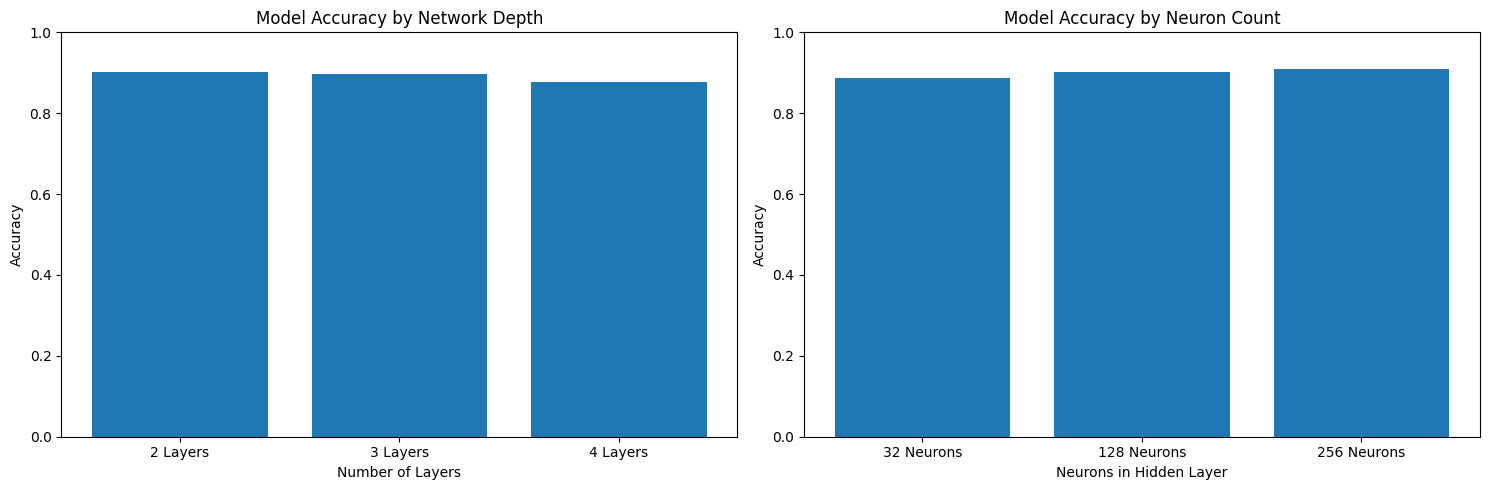

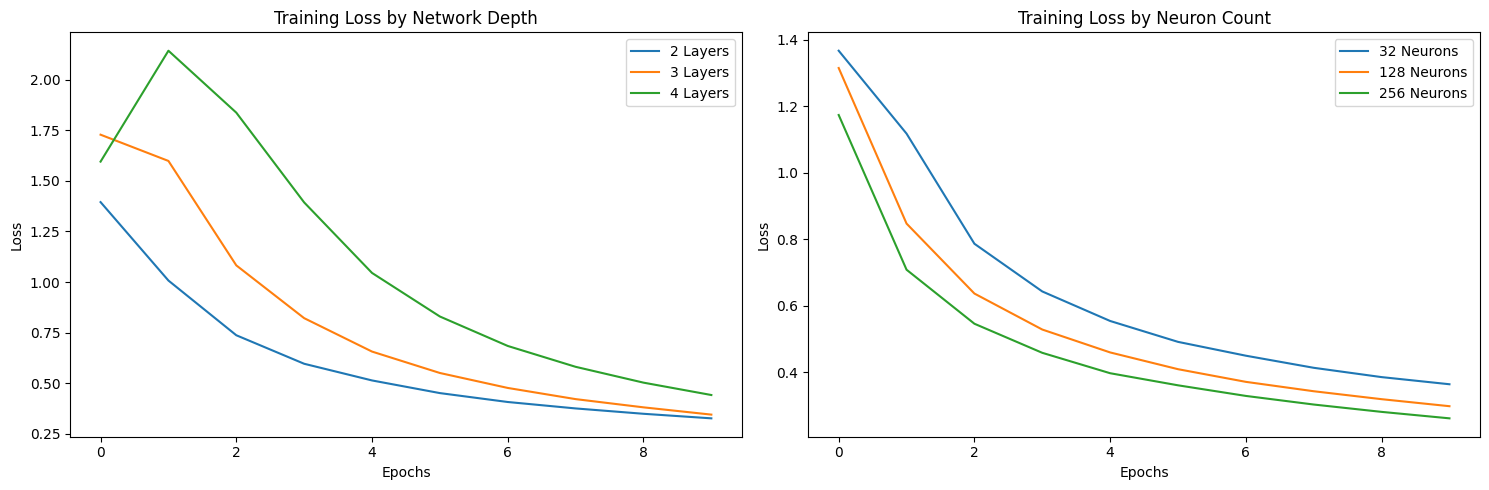

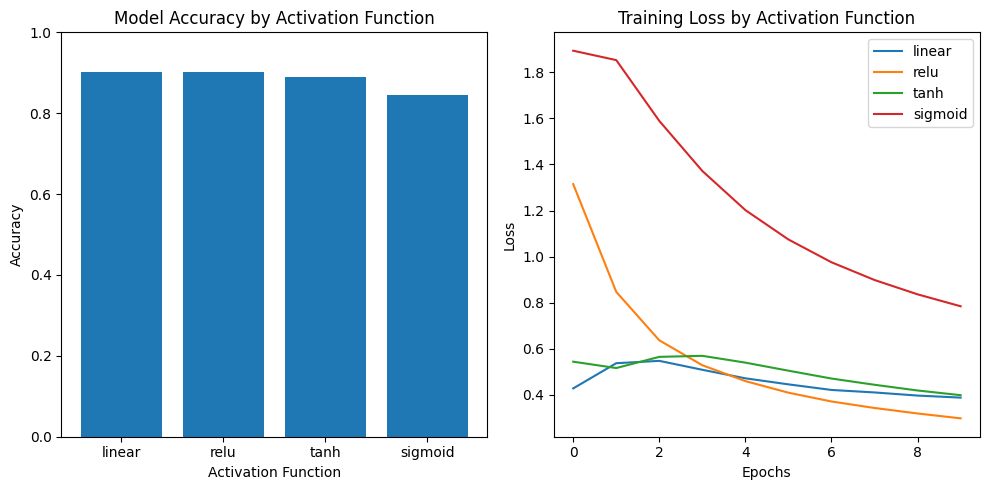

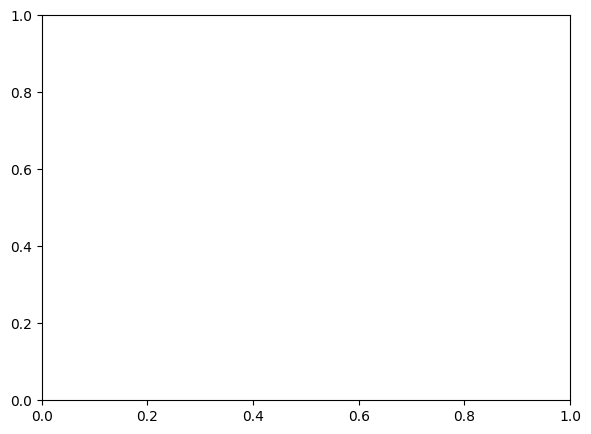

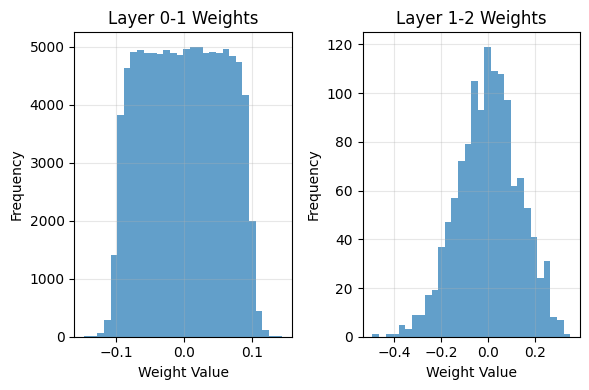

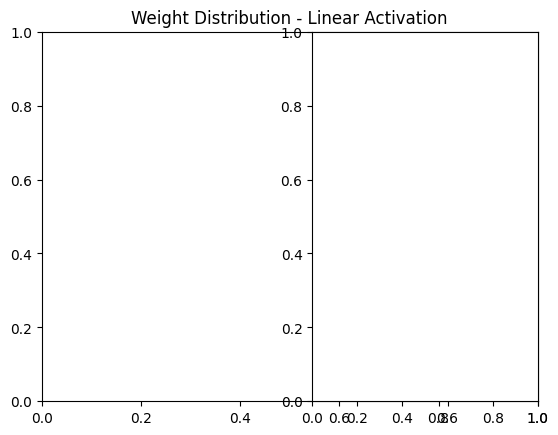

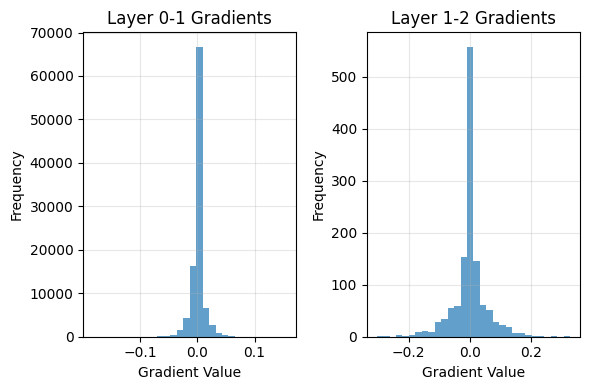

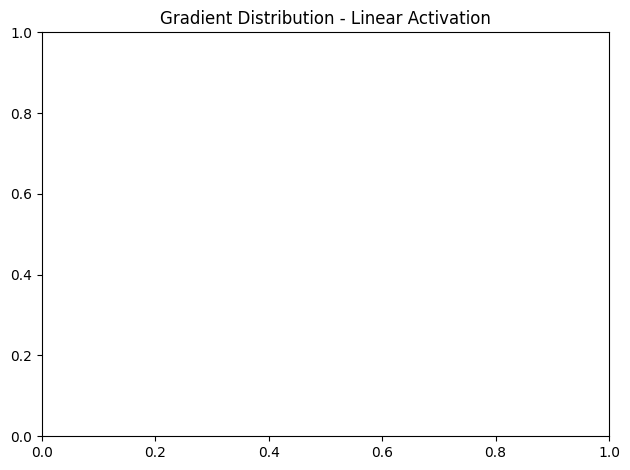

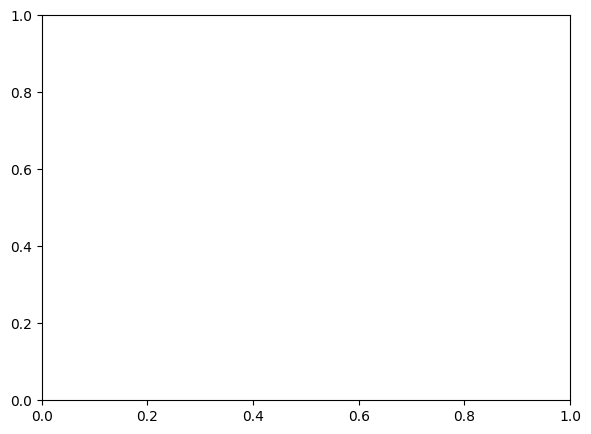

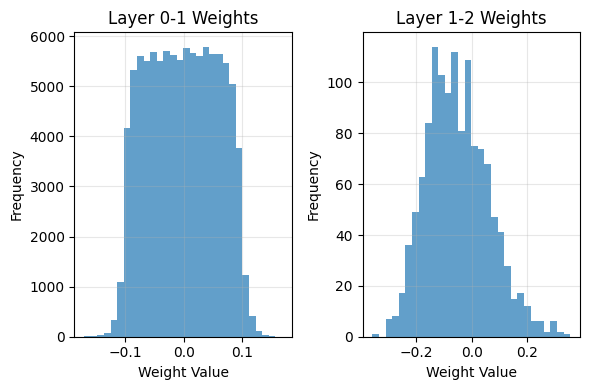

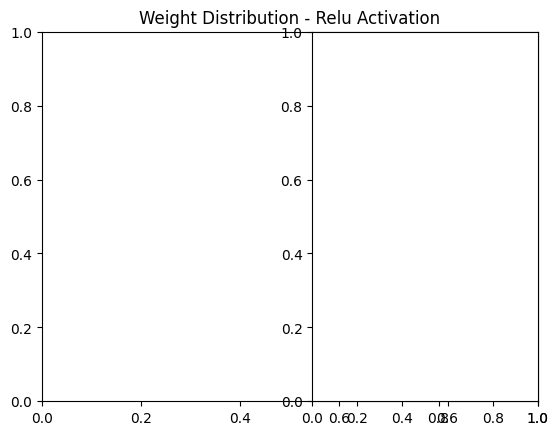

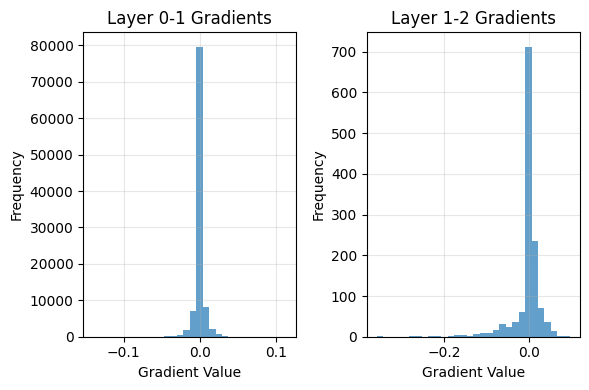

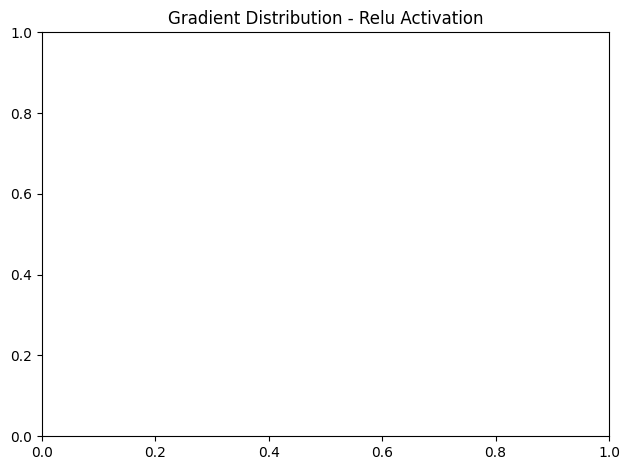

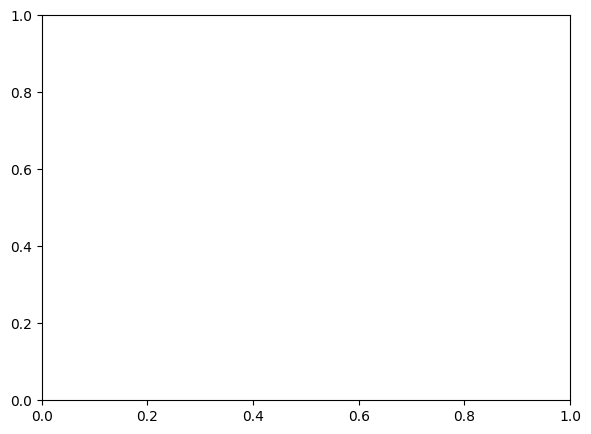

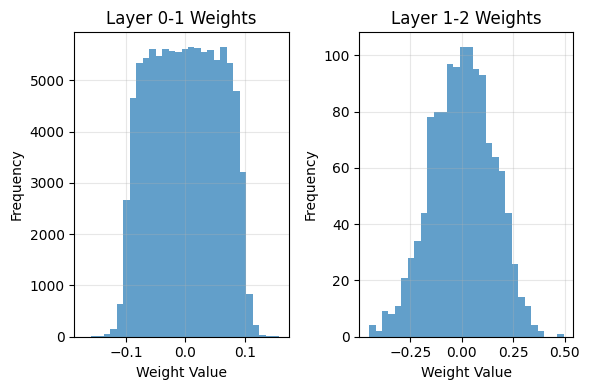

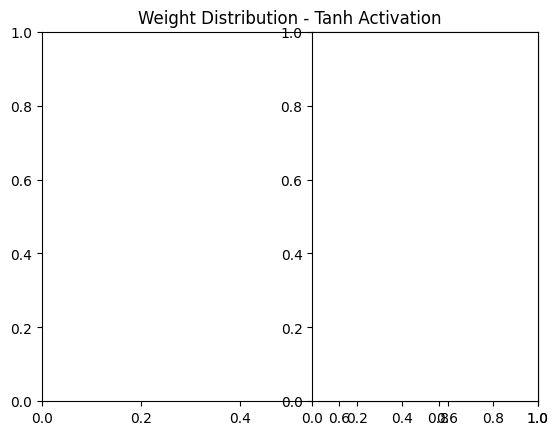

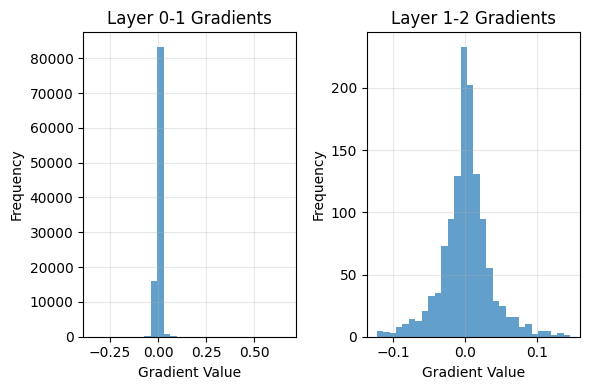

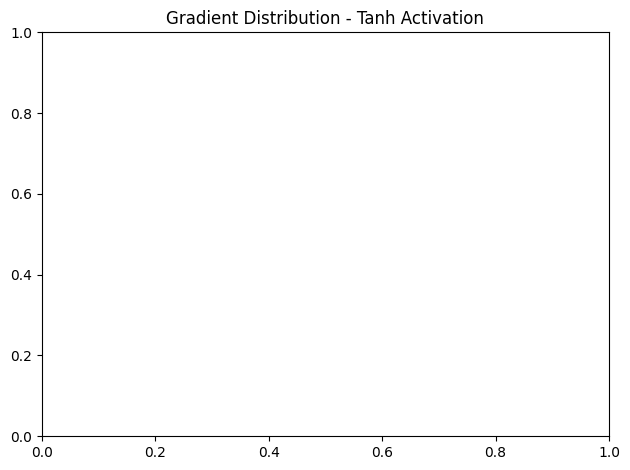

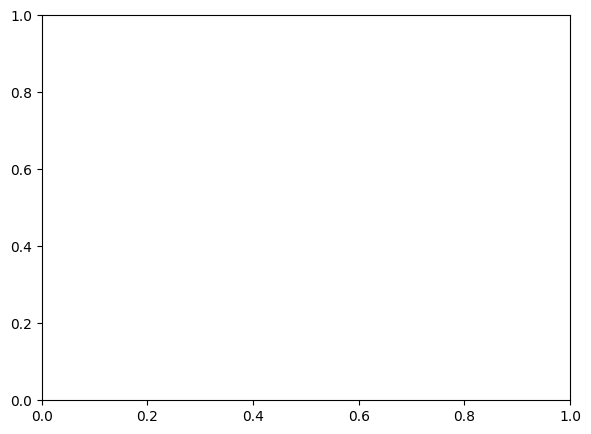

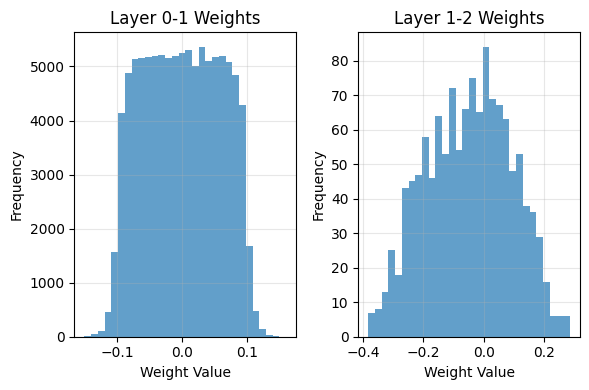

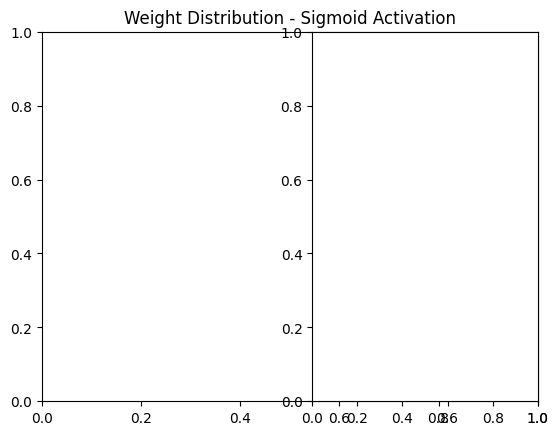

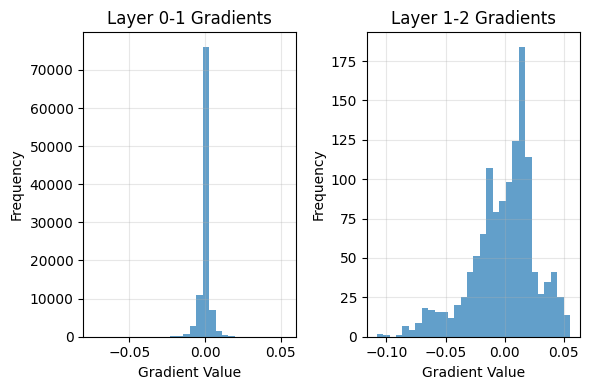

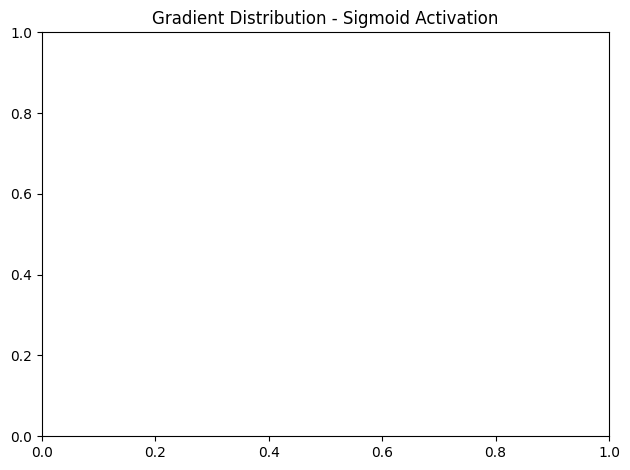

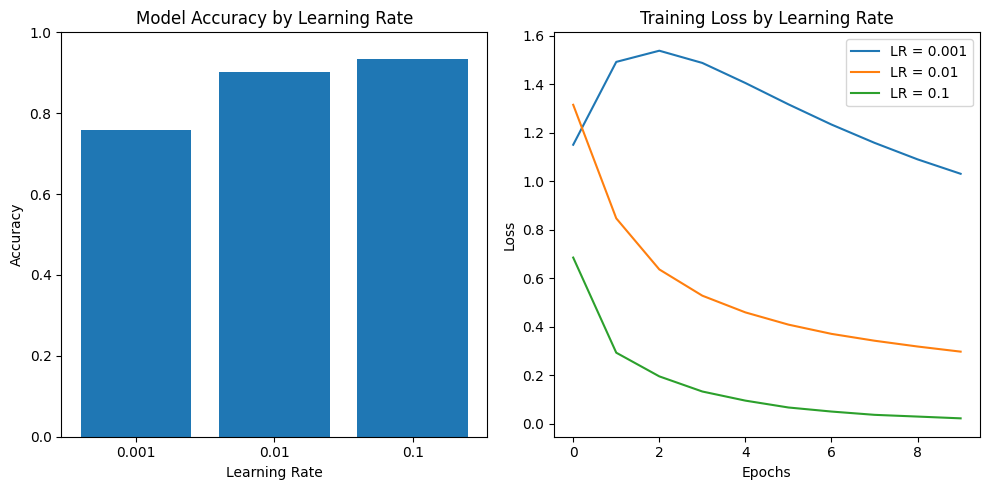

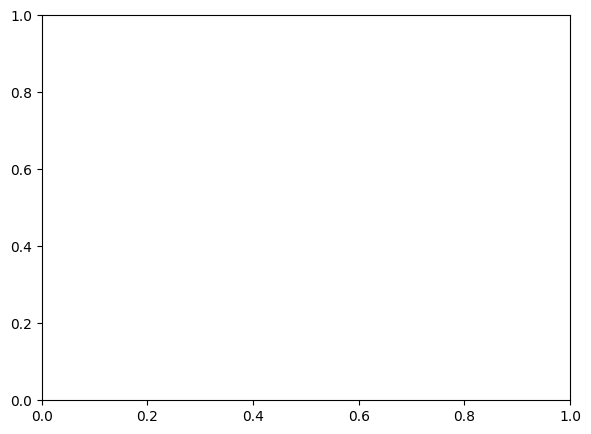

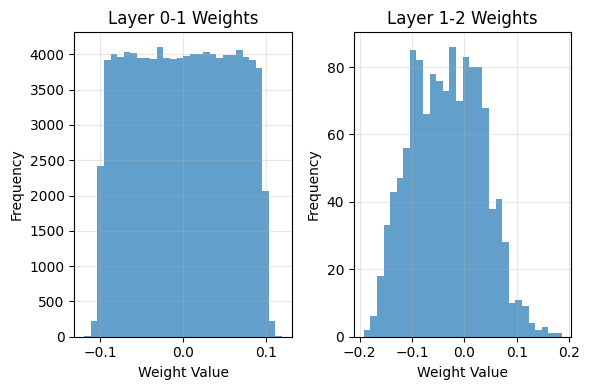

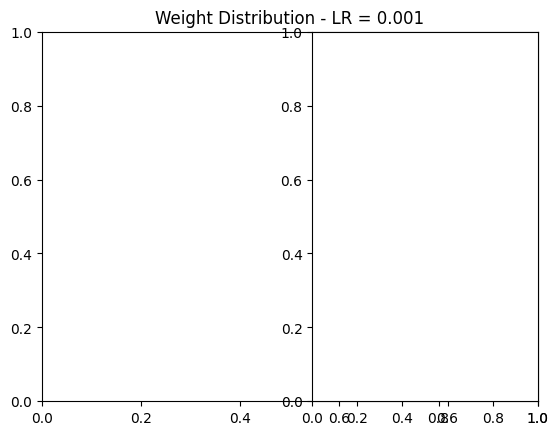

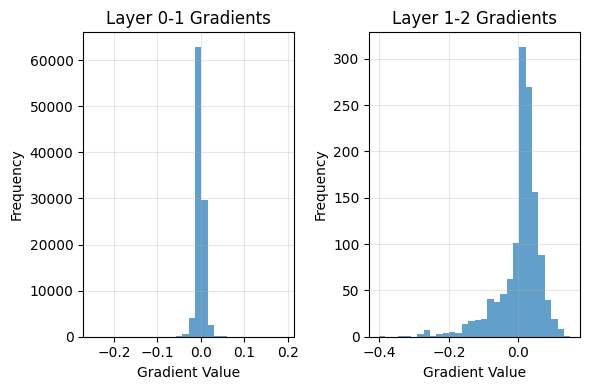

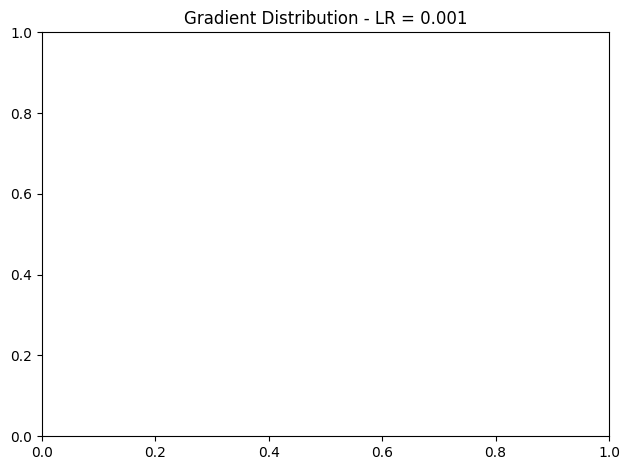

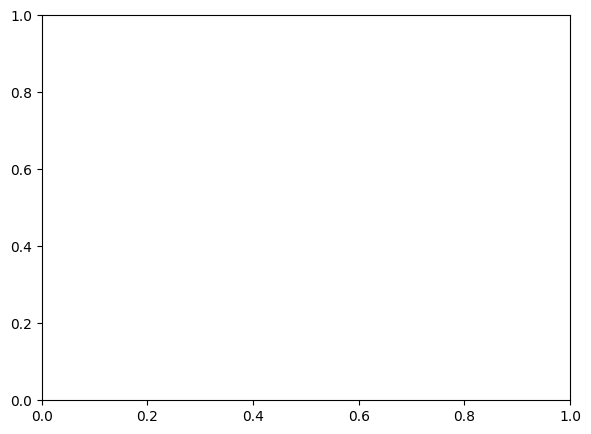

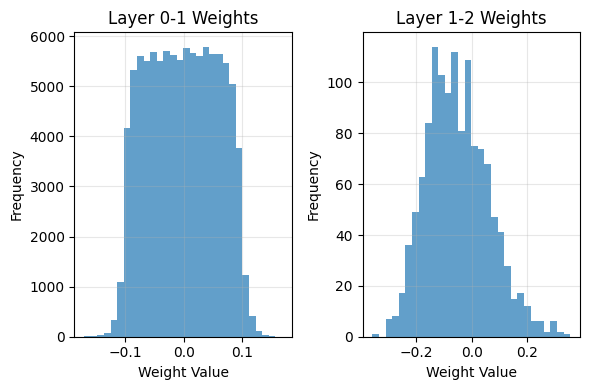

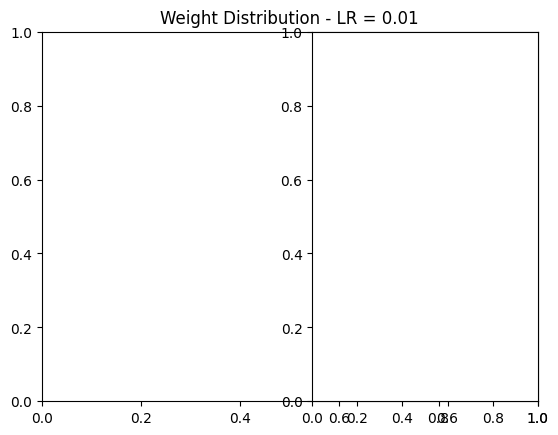

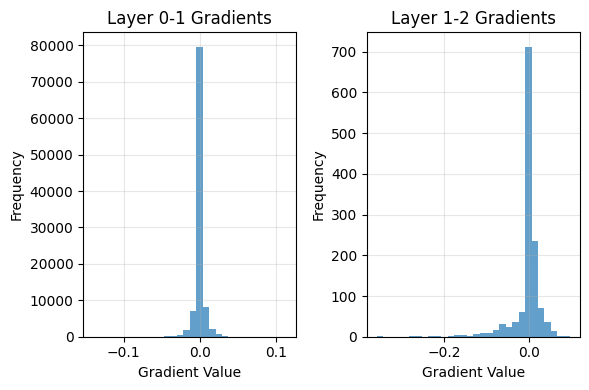

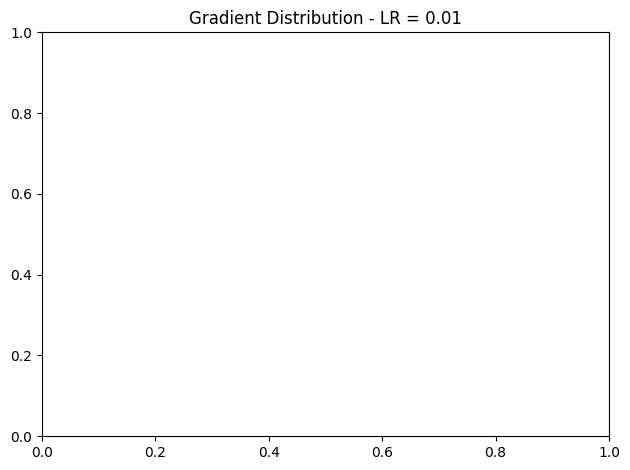

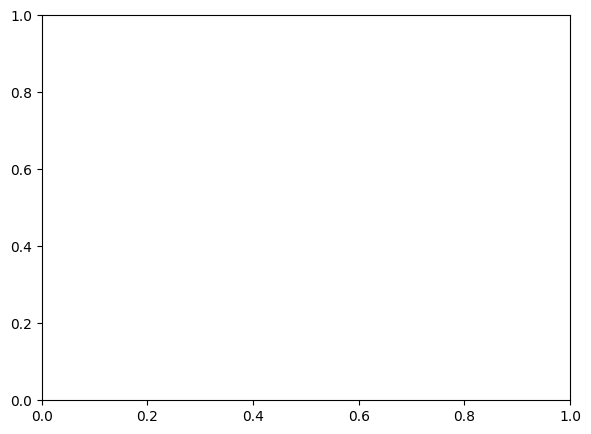

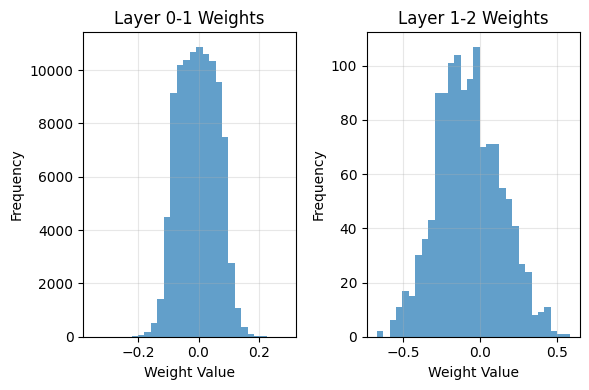

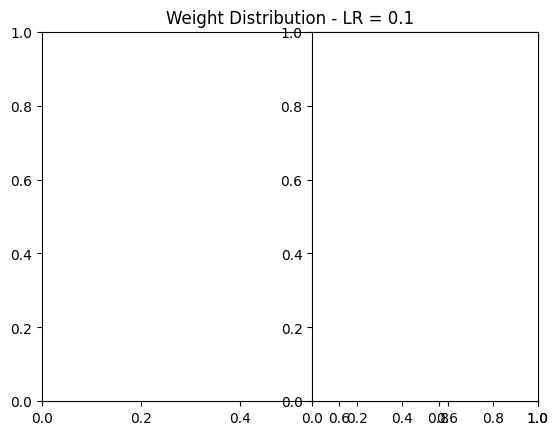

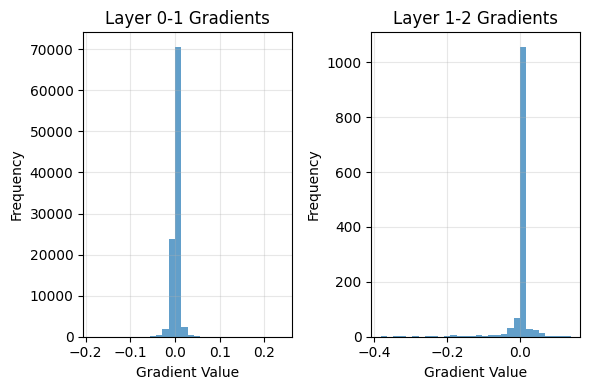

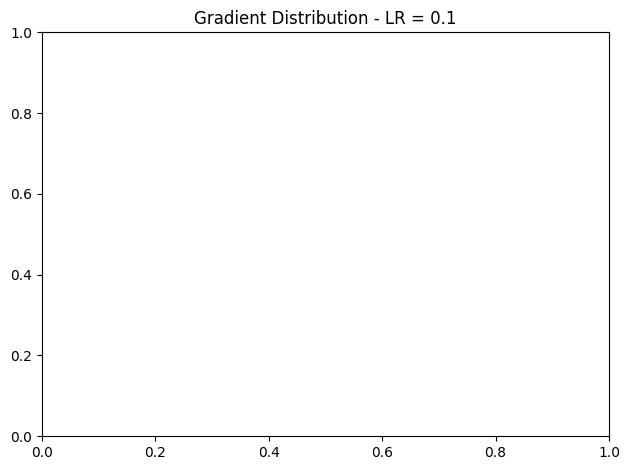

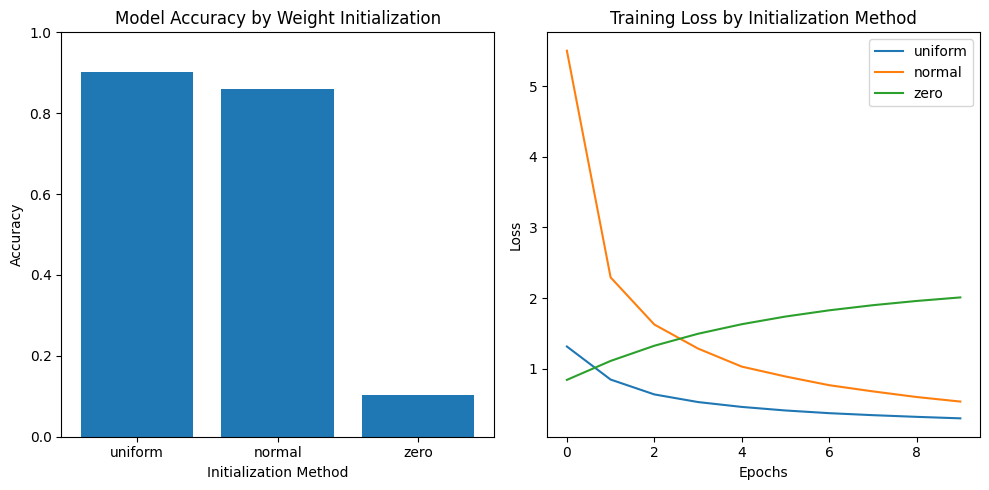

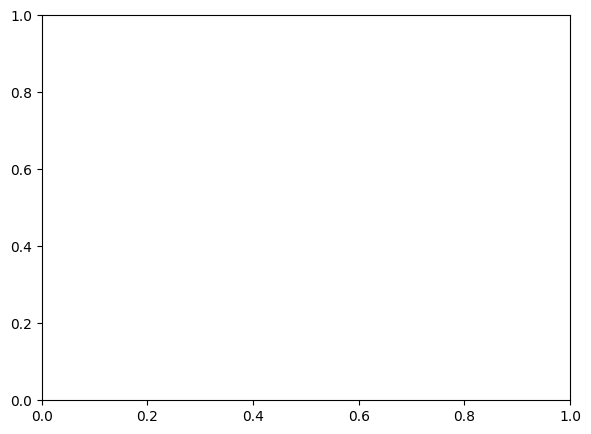

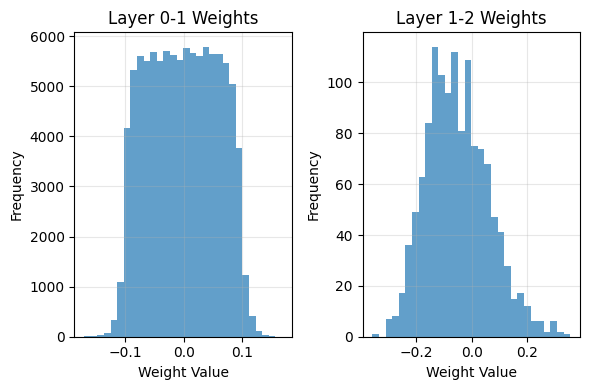

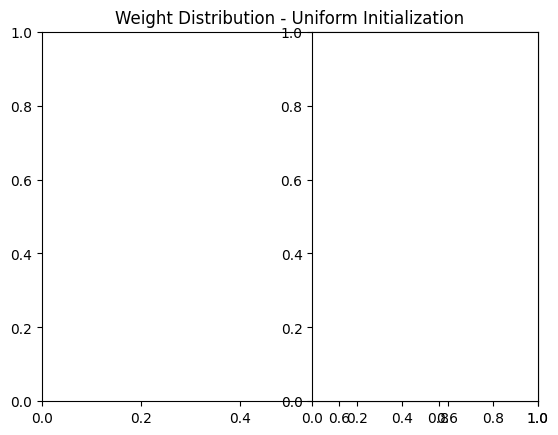

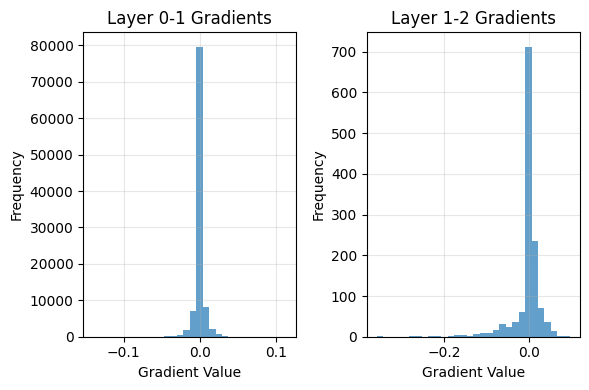

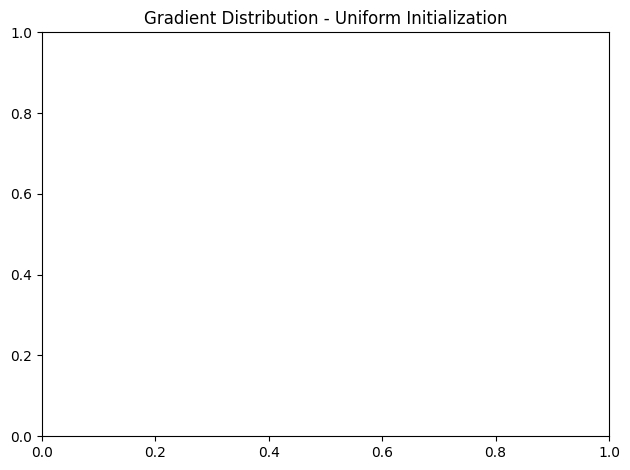

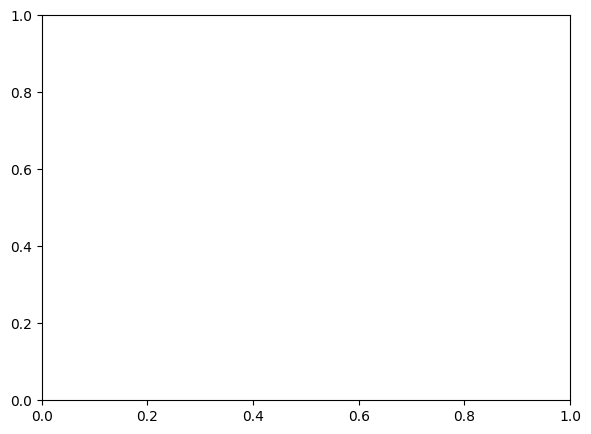

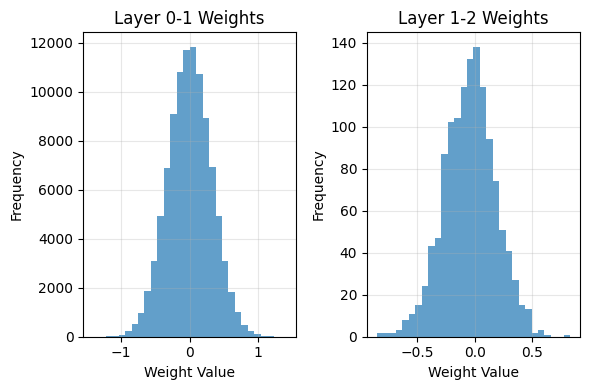

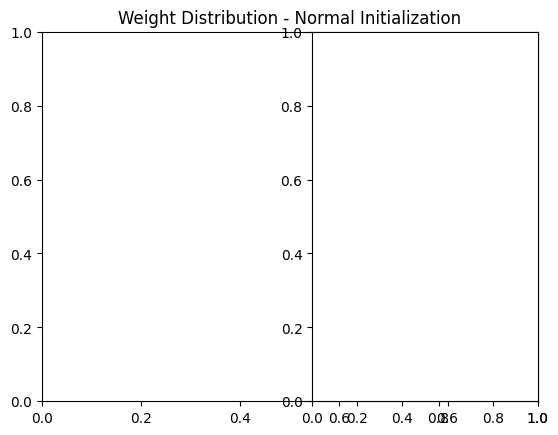

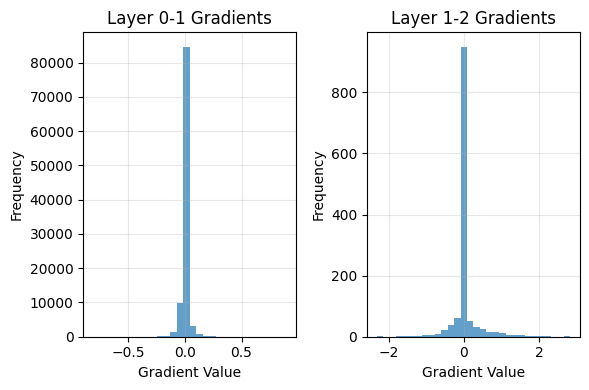

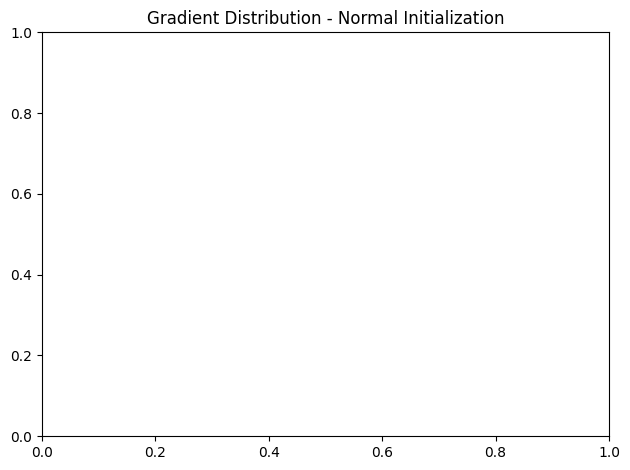

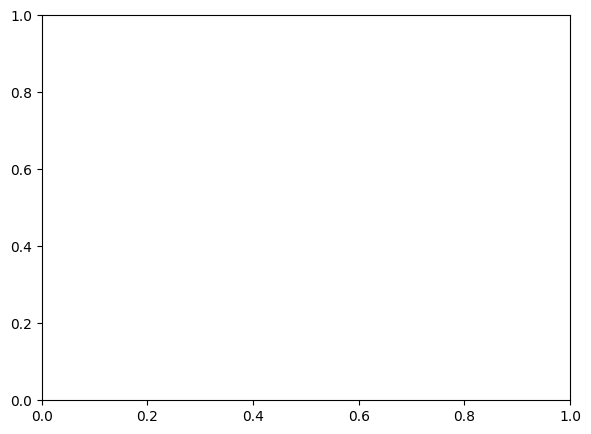

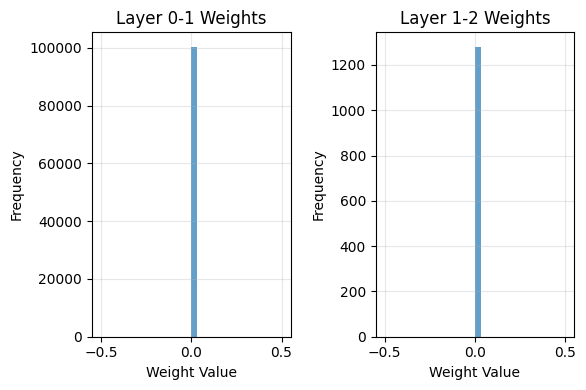

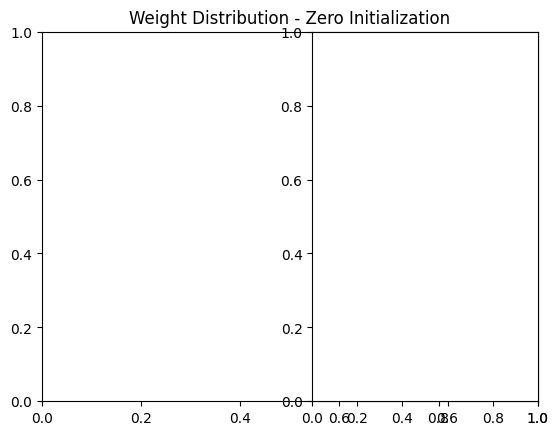

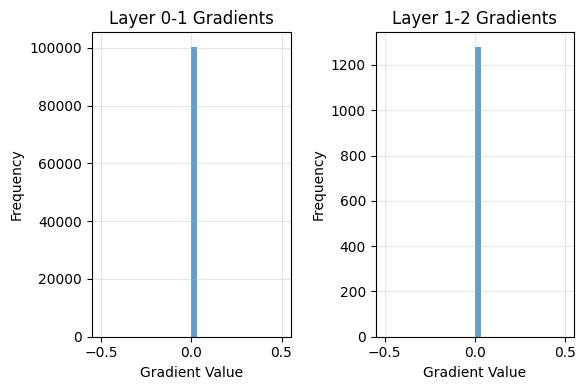

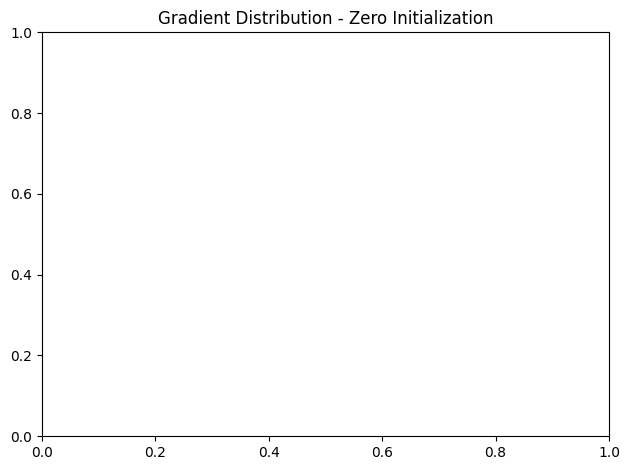

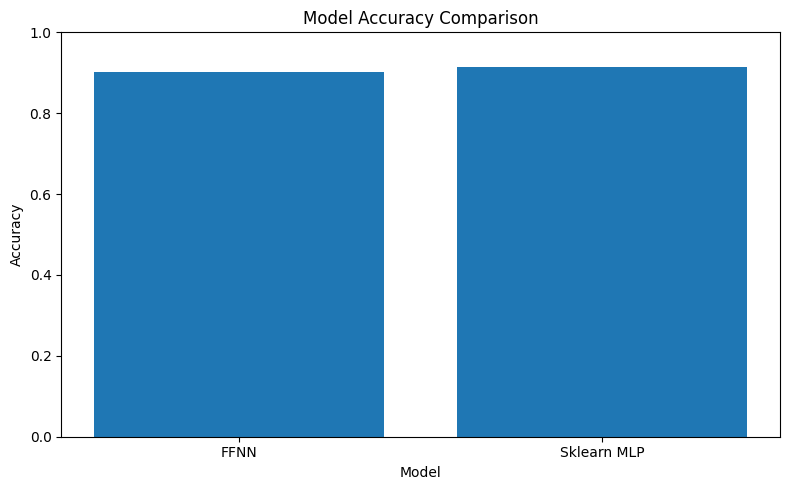

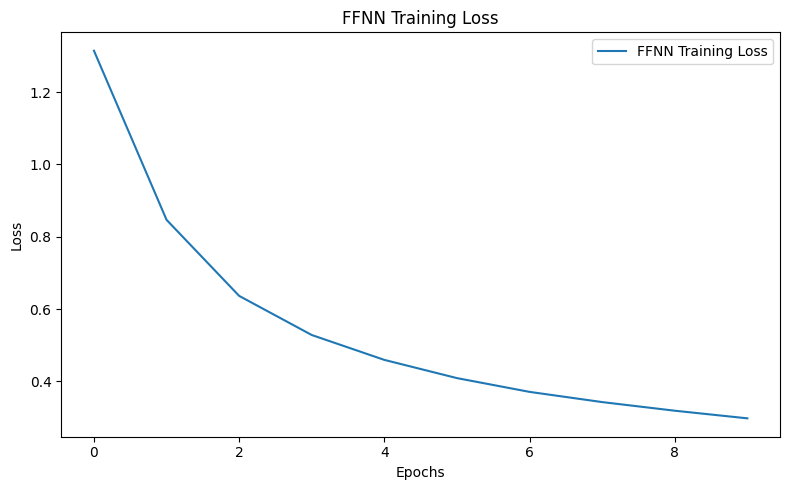

In [51]:
run_comprehensive_visualizations(
    depth_results, 
    width_results, 
    activation_results, 
    lr_results, 
    init_results, 
    mlp_comparison
)